In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import tqdm
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import wandb
import seaborn as sns

from utils import *
from train import *

# for tensorboard
from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter()

# Using embedding
In this experiment, we sample data not only from uniform distribution but from variety of distributions. We then use this data for encoder and feed its output throught cross-attention mechanism to the decoder. The decoder takes the sequence with missing tokens and tries to fill in the gaps.

### Architecture
- We use multihead attention for the encoder and vanilla attention for the decoder.
- In the encoder, before splitting heads I "merge" the 5 sequences through linear layer.

In [2]:
import os
print(os.getcwd())

/Users/mariayuffa/semester-project-1


In [3]:
'''
# Sequences for decoder
final_chains_train = np.load('data/final_chains_T=1_num_iters=20_J_experiment_train.npy')
chains_train = final_chains_train.copy()
chains_train[final_chains_train==-1] = 0
chains_train[final_chains_train==1] = 1
#dec_samples_train = torch.tensor(chains_train, dtype=torch.long)
print("Loaded train sequences of proteins sampled from Boltzmann distribution:", final_chains_train.shape)

final_chains_test = np.load('data/final_chains_T=1_num_iters=20_J_experiment_test.npy')
chains_test = final_chains_test.copy()
chains_test[final_chains_test==-1] = 0
chains_test[final_chains_test==1] = 1
#dec_samples_test = torch.tensor(chains_test, dtype=torch.long)
print("Loaded test sequences of proteins sampled from Boltzmann distribution:", final_chains_test.shape)


# Sequences for encoder
final_chains_encoder_train = np.zeros((1000,5,200))
final_chains_encoder_test = np.zeros((1000,5,200))
for i in range(1,6):
    final_chains_encoder_train[:,i-1,:] = np.load(f'data/2_spin/cluster_ising/final_chains_T=1_num_iters=5_J_experiment_train_{i}.npy')
    final_chains_encoder_test[:,i-1,:] = np.load(f'data/2_spin/cluster_ising/final_chains_T=1_num_iters=5_J_experiment_test_{i}.npy') 

print("Loaded train sequences of proteins for encoder distribution:", final_chains_encoder_train.shape)
print("Loaded test sequences of proteins for encoder distribution:", final_chains_encoder_test.shape)

samples_train = final_chains_encoder_train.copy() 
samples_train[final_chains_encoder_train==-1] = 0
samples_train[final_chains_encoder_train==1] = 1
samples_train = samples_train.reshape((5000,200))
#enc_samples_train = torch.tensor(samples_train, dtype=torch.long)

samples_test = final_chains_encoder_test.copy()
samples_test[final_chains_encoder_test==-1] = 0
samples_test[final_chains_encoder_test==1] = 1
samples_test = samples_test.reshape((5000,200))
#print(samples_test.shape)
#enc_samples_test = torch.tensor(samples_test, dtype=torch.long)

J_large = np.load("data/contact_mat/J_large.npy")
dec_samples = np.load("data/train_large.npy")
dec_samples = (dec_samples+1)/2
print(dec_samples.shape)
#t = np.load("data/2_spin/cluster_ising/final_chains_T=1_num_iters=5_J_experiment_train_5.npy")
#sns.heatmap(t, cmap="viridis")
'''


'\n# Sequences for decoder\nfinal_chains_train = np.load(\'data/final_chains_T=1_num_iters=20_J_experiment_train.npy\')\nchains_train = final_chains_train.copy()\nchains_train[final_chains_train==-1] = 0\nchains_train[final_chains_train==1] = 1\n#dec_samples_train = torch.tensor(chains_train, dtype=torch.long)\nprint("Loaded train sequences of proteins sampled from Boltzmann distribution:", final_chains_train.shape)\n\nfinal_chains_test = np.load(\'data/final_chains_T=1_num_iters=20_J_experiment_test.npy\')\nchains_test = final_chains_test.copy()\nchains_test[final_chains_test==-1] = 0\nchains_test[final_chains_test==1] = 1\n#dec_samples_test = torch.tensor(chains_test, dtype=torch.long)\nprint("Loaded test sequences of proteins sampled from Boltzmann distribution:", final_chains_test.shape)\n\n\n# Sequences for encoder\nfinal_chains_encoder_train = np.zeros((1000,5,200))\nfinal_chains_encoder_test = np.zeros((1000,5,200))\nfor i in range(1,6):\n    final_chains_encoder_train[:,i-1,:] 

In [4]:

samples_train = np.load("data/data_enc_example_big.npy")
#add_true = np.load("data/data_enc_example_new_add.npy")
#add_true = add_true.reshape(1, add_true.shape[0], add_true.shape[1])
#samples_train = np.concatenate((samples_train,add_true), axis=0)

samples_train = samples_train.reshape(samples_train.shape[0]*samples_train.shape[1], samples_train.shape[-1])
samples_train = (samples_train+1)/2

chains_train = np.load("data/data_dec_example_big.npy")
chains_train = (chains_train+1)/2

J = np.load("data/contact_mat/J_enc_big.npy")

print("Loaded train encoder sequences:", samples_train.shape)
print("Loaded train decoder sequences:", chains_train.shape)
'''
samples_train = np.load("data/data_enc_example_new.npy")
#add_true = np.load("data/data_enc_example_new_add.npy")
#add_true = add_true.reshape(1, add_true.shape[0], add_true.shape[1])
#samples_train = np.concatenate((samples_train,add_true), axis=0)

samples_train = samples_train.reshape(samples_train.shape[0]*samples_train.shape[1], samples_train.shape[-1])
samples_train = (samples_train+1)/2

chains_train = np.load("data/train_example_new.npy")
chains_train = (chains_train+1)/2

J = np.load("data/contact_mat/J_example_new.npy")

print("Loaded train encoder sequences:", samples_train.shape)
print("Loaded train decoder sequences:", chains_train.shape)
'''


Loaded train encoder sequences: (50000, 200)
Loaded train decoder sequences: (10000, 200)


'\nsamples_train = np.load("data/data_enc_example_new.npy")\n#add_true = np.load("data/data_enc_example_new_add.npy")\n#add_true = add_true.reshape(1, add_true.shape[0], add_true.shape[1])\n#samples_train = np.concatenate((samples_train,add_true), axis=0)\n\nsamples_train = samples_train.reshape(samples_train.shape[0]*samples_train.shape[1], samples_train.shape[-1])\nsamples_train = (samples_train+1)/2\n\nchains_train = np.load("data/train_example_new.npy")\nchains_train = (chains_train+1)/2\n\nJ = np.load("data/contact_mat/J_example_new.npy")\n\nprint("Loaded train encoder sequences:", samples_train.shape)\nprint("Loaded train decoder sequences:", chains_train.shape)\n'

In [5]:
enc_train_loader = create_dataloaders(samples_train, batch_size=160, flag_float=False)
dec_train_loader = create_dataloaders(chains_train, batch_size=32, flag_float=False)


In [6]:
'''
# Sequences for decoder
final_chains_train = np.load('data/final_chains_T=1_num_iters=20_J_experiment_train.npy')
chains_train = final_chains_train.copy()
chains_train[final_chains_train==-1] = 1
chains_train[final_chains_train==1] = 3
tensor_chains_train = torch.tensor(chains_train, dtype=torch.long)
print("Loaded train sequences of proteins sampled from Boltzmann distribution:", final_chains_train.shape)

final_chains_test = np.load('data/final_chains_T=1_num_iters=20_J_experiment_test.npy')
chains_test = final_chains_test.copy()
chains_test[final_chains_test==-1] = 1 
chains_test[final_chains_test==1] = 3 
tensor_chains_test = torch.tensor(chains_test, dtype=torch.long)
print("Loaded test sequences of proteins sampled from Boltzmann distribution:", final_chains_test.shape)


# Sequences for encoder
k = 0
final_chains_encoder_train = np.zeros((1000,5,200))
final_chains_encoder_train[:,0,:] = np.load('data/2_spin/final_chains_T=1_num_iters=400_J=10_test.npy') 
final_chains_encoder_test = np.zeros((1000,5,200))
final_chains_encoder_test[:,0,:] = np.load('data/2_spin/final_chains_T=1_num_iters=400_J=10_test.npy') 
for i in range(20,100,20):
    k+=1
    final_chains_encoder_train[:,k,:] = np.load('data/2_spin/final_chains_T=1_num_iters=400_J='+str(i)+'_train.npy')
    final_chains_encoder_test[:,k,:] = np.load('data/2_spin/final_chains_T=1_num_iters=400_J='+str(i)+'_test.npy') 

print("Loaded train sequences of proteins for encoder distribution:", final_chains_encoder_train.shape)
print("Loaded test sequences of proteins for encoder distribution:", final_chains_encoder_test.shape)

samples_train = final_chains_encoder_train.copy() 
samples_train[final_chains_encoder_train==-1] = 1
samples_train[final_chains_encoder_train==1] = 3
tensor_samples_train = torch.tensor(samples_train, dtype=torch.long)

samples_test = final_chains_encoder_test.copy()
samples_test[final_chains_encoder_test==-1] = 1
samples_test[final_chains_encoder_test==1] = 3
tensor_samples_test = torch.tensor(samples_test, dtype=torch.long)
'''

'\n# Sequences for decoder\nfinal_chains_train = np.load(\'data/final_chains_T=1_num_iters=20_J_experiment_train.npy\')\nchains_train = final_chains_train.copy()\nchains_train[final_chains_train==-1] = 1\nchains_train[final_chains_train==1] = 3\ntensor_chains_train = torch.tensor(chains_train, dtype=torch.long)\nprint("Loaded train sequences of proteins sampled from Boltzmann distribution:", final_chains_train.shape)\n\nfinal_chains_test = np.load(\'data/final_chains_T=1_num_iters=20_J_experiment_test.npy\')\nchains_test = final_chains_test.copy()\nchains_test[final_chains_test==-1] = 1 \nchains_test[final_chains_test==1] = 3 \ntensor_chains_test = torch.tensor(chains_test, dtype=torch.long)\nprint("Loaded test sequences of proteins sampled from Boltzmann distribution:", final_chains_test.shape)\n\n\n# Sequences for encoder\nk = 0\nfinal_chains_encoder_train = np.zeros((1000,5,200))\nfinal_chains_encoder_train[:,0,:] = np.load(\'data/2_spin/final_chains_T=1_num_iters=400_J=10_test.npy\

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import tqdm
import random
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from utils import *

############################################### Transformer Model ################################################
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = embed_dim
        self.num_heads = num_heads
        self.d_k = embed_dim // num_heads
        
        self.W_q = nn.Linear(embed_dim, embed_dim) # Linear layer for query 
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.W_o = nn.Linear(embed_dim, embed_dim) # Output layer to ensure that dimensionality matches the model's expected dimensionality
        
        self.combine_heads = nn.Linear(num_heads, 1)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, embed_dim = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
     
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size,seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        #print("shape of Q before splitting heads:", Q.shape)
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        #print("shape of Q after splitting heads:", Q.shape)
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        #print(" before W_o:", self.combine_heads(attn_output.permute(1,2,0)).squeeze(-1).shape)
        output = self.W_o(self.combine_heads(attn_output))
        return output
    
class VanillaAttention(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(VanillaAttention, self).__init__()
        self.word_embeddings = nn.Linear(num_spins, embed_dim)
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a  # parameter controlling how important positions are
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc1 = nn.Linear(embed_dim, embed_dim)  # output layer
        self.fc2 = nn.Linear(embed_dim, embed_dim)  # output layer
        self.dropout = nn.Dropout(dropout_rate)
        self.scale = math.sqrt(embed_dim)

    def forward(self, s, enc_output):
        # Vanilla attention has the same architecture as the one in simple transformer

        batch_size_decoder = s.shape[0]
        batch_size_encoder = enc_output.shape[0]
        if batch_size_decoder != batch_size_encoder:
            s = s.repeat(batch_size_encoder // batch_size_decoder, 1, 1)

        query = self.query_weight(s)
        key = self.key_weight(enc_output)
        values = self.value_weight(enc_output)
        scores = torch.matmul(query, key.transpose(-2, -1)) / self.scale # Transpose last two dimensions for matrix multiplication
        attn_weights = torch.softmax(scores, dim=-1)  # Apply softmax to scores to get probabilities

        # Apply attention scores to values
        output= torch.matmul(attn_weights, values)
        if batch_size_decoder != batch_size_encoder:
            output = output.view(batch_size_decoder, batch_size_encoder // batch_size_decoder, output.size(-2), output.size(-1)).mean(dim=1)

        output = self.fc2(torch.relu(self.fc1(self.dropout(output)))) # should have size (20,3)
        return output, attn_weights
    
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        #return x + self.pe[:, :x.size(1)]
        return x + self.pe[:, :, :x.size(2)]
    
class EncoderLayer(nn.Module):
    def __init__(self, embed_dim, proj_layer_dim, dropout, num_distr=5):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(embed_dim=embed_dim, num_heads=num_distr)
        self.feed_forward = PositionWiseFeedForward(d_model=embed_dim, d_ff=proj_layer_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_distr,1)
        
    def forward(self, x):
        #x = self.fc(x.permute(1,2,0)).permute(2,0,1)
        attn_output = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x
    
class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = VanillaAttention(embed_dim=embed_dim, a=a, max_seq_length=max_seq_length, num_spins=num_spins, dropout_rate=dropout)# masking one of the word in the sequence
        self.cross_attn = VanillaAttention(embed_dim=embed_dim, a=a, max_seq_length=max_seq_length, num_spins=num_spins, dropout_rate=dropout)
        self.feed_forward = PositionWiseFeedForward(d_model=embed_dim, d_ff=proj_layer_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

        self.cross_attn_weights = None
        self.decoder_attn_weights = None
        
    def forward(self, x, enc_output):
        enc_output = enc_output.squeeze(0)
        attn_output, decoder_attn_weights = self.self_attn(x, x)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output, cross_attn_weights = self.cross_attn(x, enc_output)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        #x = x.sum(dim=0)
        self.cross_attn_weights = cross_attn_weights 
        self.decoder_attn_weights = decoder_attn_weights
        return x
    

In [8]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout, num_distr=5):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(num_spins, embed_dim)
        self.decoder_embedding = nn.Embedding(num_spins, embed_dim)

        #self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        #self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.positional_encoding = PositionalEncoding(embed_dim, max_seq_length)
        self.positional_embedding = nn.Embedding(max_seq_length, embed_dim)
        self.encoder_layer = EncoderLayer(embed_dim, proj_layer_dim, dropout, num_distr)
        self.decoder_layer = DecoderLayer(embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout)
        self.a = a
        self.fc = nn.Linear(embed_dim, num_spins-1)

    def forward(self, src, tgt):
        #src_mask, tgt_mask = self.generate_mask(src, tgt)
        #src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        #tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        
        src_embedded = self.positional_encoding(self.encoder_embedding(src))

        tgt_embedded = self.decoder_embedding(tgt)
        position_ids = torch.arange(tgt_embedded.shape[1], dtype=torch.long).unsqueeze(0).expand(tgt_embedded.shape[0], tgt_embedded.shape[1])
        position_embeddings = self.positional_embedding(position_ids)
        tgt_embedded = tgt_embedded + self.a * position_embeddings

        enc_output = self.encoder_layer(src_embedded)
        dec_output = self.decoder_layer(tgt_embedded, enc_output)
        output = self.fc(torch.relu(dec_output))
        #print("output of the transformer:", output.shape)
        return output
    
    def get_cross_attention_weights(self):
        return self.decoder_layer.cross_attn_weights
    
    def get_self_attention_weights(self):
        return self.decoder_layer.decoder_attn_weights

## Training and validation

In [9]:
# Define the parameters 
vocab_size = 3
vocab = {0:0,1:1,2:2} 
L = 200
embedding_dim = 200
proj_layer_dim = 128
hidden_dim = 200
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-3
num_sequences = 1000
num_epochs = 15
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


### Tracking the results

In [10]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="cross_attention_experiment",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "Transformer",
    "dataset": "ms_sequences_with_different_probability",
    "epochs": num_epochs,
    }

)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: marindigen. Use `wandb login --relogin` to force relogin


In [11]:
def train(model, data_train, data_train_dec, vocab, optimizer, criterion, num_epochs=20, device=0):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    # Training loop
    model.train()
    best_eval_loss = 1e-3 # used to do early stopping

    for epoch in tqdm.tqdm(range(num_epochs), leave=False, position=0):
        running_loss = 0
        epoch_loss = 0
        store_cross_attn_weights = []
        store_decoder_attn_weights = []
        for data_enc, data_dec in zip(data_train, data_train_dec):
            # Get the inputs
            input_seq_enc = torch.tensor(data_enc, dtype=torch.long)
            input_seq_dec = torch.tensor(data_dec, dtype=torch.long)
            # mask tokens in decoder
            positions = torch.randint(0, input_seq_dec.shape[1], (input_seq_dec.shape[0], 1))
            masked_sequence = input_seq_dec.clone()
            masked_sequence[torch.arange(input_seq_dec.shape[0]), positions.squeeze(-1)] = 2
            masked_sequence = masked_sequence.long()

            # Forward pass
            predictions = model.forward(input_seq_enc, masked_sequence).squeeze(0) #masked_sequence[masked_position])
            positions = positions.squeeze(-1)

            # Compute loss
            loss = criterion(predictions[torch.arange(data_dec.shape[0]), positions], data_dec[torch.arange(data_dec.shape[0]), positions])
            epoch_loss += loss.item()

            store_cross_attn_weights.append(model.decoder_layer.cross_attn_weights)
            store_decoder_attn_weights.append(model.decoder_layer.decoder_attn_weights)
            
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(data_enc)):.4f}')
        #writer.add_scalar("Train Loss", epoch_loss / len(data_enc), epoch)
        wandb.log({"train_loss": epoch_loss / len(data_enc)})
        
    return epoch_loss / len(data_train), store_cross_attn_weights, store_decoder_attn_weights

In [12]:
# Example usage:

model = Transformer(embed_dim=embedding_dim, a=1, max_seq_length=L, num_spins=3, proj_layer_dim=128, dropout=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

#train(model, tensor_samples_train, tensor_chains_train, tensor_samples_test, tensor_chains_test, vocab, optimizer, criterion, device=device)
path = 'runs/embedding_run_5_(1,3)'
#loss, store_cross_attn_weights, store_decoder_weights = training_script(path, model, data_train=enc_train_loader, data_train_dec=dec_train_loader,
#                data_test=enc_test_loader, data_test_dec=dec_test_loader, vocab=vocab, optimizer=optimizer,
#                criterion=criterion, one_hot_flag=False, num_epochs=num_epochs, device=0)

loss, store_cross_attn_weights, store_decoder_weights = train(model, data_train=enc_train_loader,  data_train_dec=dec_train_loader, vocab=vocab, optimizer=optimizer, criterion=criterion, device=device)
#torch.save(model.state_dict(), 'models/lstm_scratch.pt')
#evaluate(model, test_dataloader, criterion, device=device)
wandb.finish()

  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_31716/1108523803.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq_enc = torch.tensor(data_enc, dtype=torch.long)
/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_31716/1108523803.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq_dec = torch.tensor(data_dec, dtype=torch.long)
  5%|▌         | 1/20 [02:07<40:22, 127.49s/it]

Epoch 1 | Train Loss: 2.7401


 10%|█         | 2/20 [04:08<37:04, 123.57s/it]

Epoch 2 | Train Loss: 2.7228


 15%|█▌        | 3/20 [06:02<33:49, 119.36s/it]

Epoch 3 | Train Loss: 2.7186


 20%|██        | 4/20 [08:03<31:59, 119.99s/it]

Epoch 4 | Train Loss: 2.7158


 25%|██▌       | 5/20 [10:03<29:57, 119.82s/it]

Epoch 5 | Train Loss: 2.7178


 30%|███       | 6/20 [11:59<27:40, 118.64s/it]

Epoch 6 | Train Loss: 2.7173


 35%|███▌      | 7/20 [13:57<25:40, 118.46s/it]

Epoch 7 | Train Loss: 2.7138


 40%|████      | 8/20 [15:56<23:41, 118.45s/it]

Epoch 8 | Train Loss: 2.7140


 45%|████▌     | 9/20 [17:53<21:40, 118.22s/it]

Epoch 9 | Train Loss: 2.7127


 50%|█████     | 10/20 [19:52<19:43, 118.34s/it]

Epoch 10 | Train Loss: 2.7130


 55%|█████▌    | 11/20 [21:50<17:44, 118.26s/it]

Epoch 11 | Train Loss: 2.7127


 60%|██████    | 12/20 [23:48<15:46, 118.29s/it]

Epoch 12 | Train Loss: 2.7140


 65%|██████▌   | 13/20 [25:47<13:49, 118.45s/it]

Epoch 13 | Train Loss: 2.7120


 70%|███████   | 14/20 [27:45<11:50, 118.34s/it]

Epoch 14 | Train Loss: 2.7111


 75%|███████▌  | 15/20 [29:43<09:51, 118.22s/it]

Epoch 15 | Train Loss: 2.7126


 80%|████████  | 16/20 [31:45<07:57, 119.45s/it]

Epoch 16 | Train Loss: 2.7121


 85%|████████▌ | 17/20 [33:45<05:58, 119.37s/it]

Epoch 17 | Train Loss: 2.7124


 90%|█████████ | 18/20 [35:42<03:57, 118.73s/it]

Epoch 18 | Train Loss: 2.7128


 95%|█████████▌| 19/20 [37:40<01:58, 118.49s/it]

Epoch 19 | Train Loss: 2.7124


Epoch 20 | Train Loss: 2.7124


train_loss,█▄▃▂▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
train_loss,2.71238


In [16]:
def plotting_heatmaps(initial_sequences, final_chains_train, title1, title2):
    # Set up a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Create a heatmap on each subplot
    sns.heatmap(initial_sequences, ax=ax1, cmap='viridis')
    ax1.set_title(title1, fontweight="bold", size=18)

    sns.heatmap(final_chains_train, ax=ax2, cmap='viridis')
    ax2.set_title(title2, fontweight="bold", size=18)

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()

# Calculate the number of true-positives
'''
def calculate_true_positives(cov_inv, J):
    """
    Calculate the number of true positives.
    Args:
        cov_inv (np.array): Inverse covariance matrix.
        J (np.array): True interaction matrix.
    Returns:
        int: Number of true positives.
    """
    TP = 0
    num_positives = np.sum(J==1)
    for c, j in zip(cov_inv, J):
        if (c == j) and (c == 1):
            TP += 1
    return TP, TP/num_positives
'''
def calculate_true_positives(cov_inv, J):
    """
    Calculate the number of true positives.
    Args:
        cov_inv (np.array): Inverse covariance matrix.
        J (np.array): True interaction matrix.
    Returns:
        int: Number of true positives.
    """
    TP = 0
    FP = 0
    for c, j in zip(cov_inv, J):
        if (c == j) and (c == 1):
            TP += 1
        elif (c != j) and (c == 1):
            FP += 1
    if TP+FP==0:
        return TP, 0
    return TP, TP/(TP+FP)



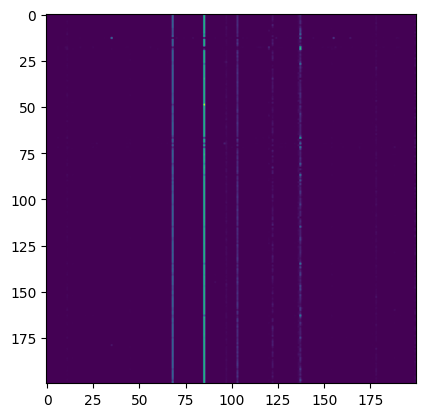

In [17]:
decoder_weights = torch.vstack(store_decoder_weights)
weights = decoder_weights.detach().numpy().mean(axis=0)
plt.imshow(weights)

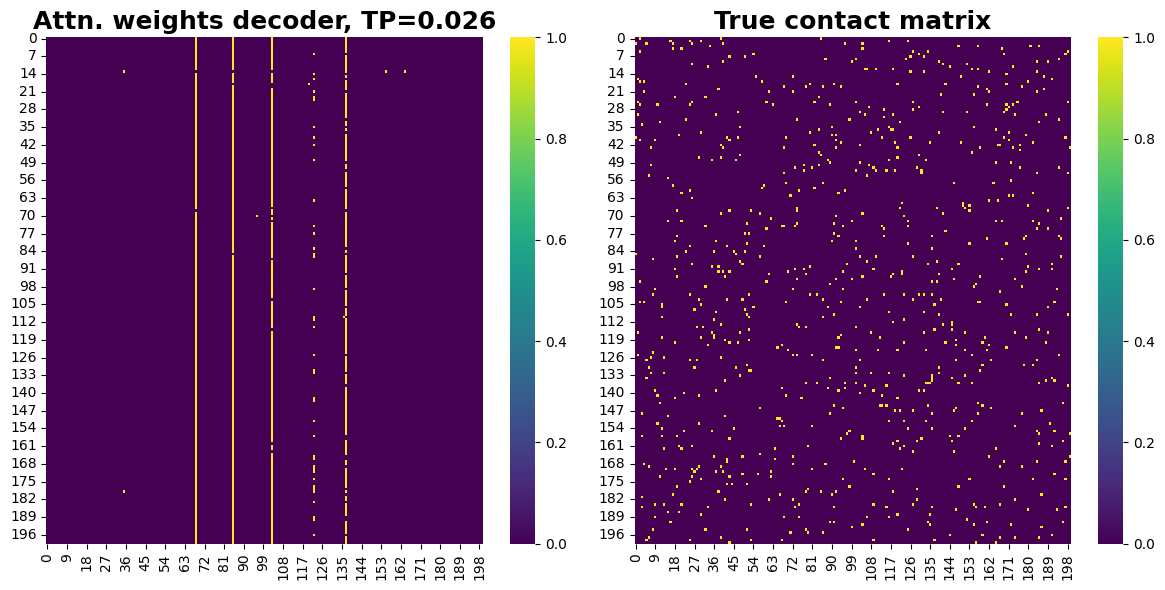

(21, 0.02625)

In [18]:
decoder_weights = torch.vstack(store_decoder_weights)
weights = decoder_weights.detach().numpy().mean(axis=0)
np.fill_diagonal(weights, 0)
threshold_mi = np.percentile(weights, 98)
weights = np.where(weights > threshold_mi, 1, 0)
plotting_heatmaps(weights, J, f"Attn. weights decoder, TP={round(calculate_true_positives(weights.flatten(), J.flatten())[1],3)}", "True contact matrix")
calculate_true_positives(weights.flatten(), J.flatten())

In [436]:
# To save only the decoder layer weights
#torch.save(model.decoder_layer.state_dict(), 'model_decoder/decoder_weights_experiment_batch.pth')
#torch.save(model.get_cross_attention_weights(), 'model_decoder/transformer_cross_attn_weights_experiment_batch.pth')
#torch.save(model.get_self_attention_weights(), 'model_decoder/transformer_dec_attn_weights_experiment_batch.pth')
#torch.save(model.fc.state_dict(), 'model_decoder/transformer_fc_weights_batch.pth')

In [12]:
cross_weights = cross_attention_weights.squeeze(0).detach().cpu().numpy()
decoder_weights = self_attention_weights.squeeze(0).detach().cpu().numpy()
print(cross_weights.shape)
print(decoder_weights.shape)

(32, 200, 200)
(8, 200, 200)


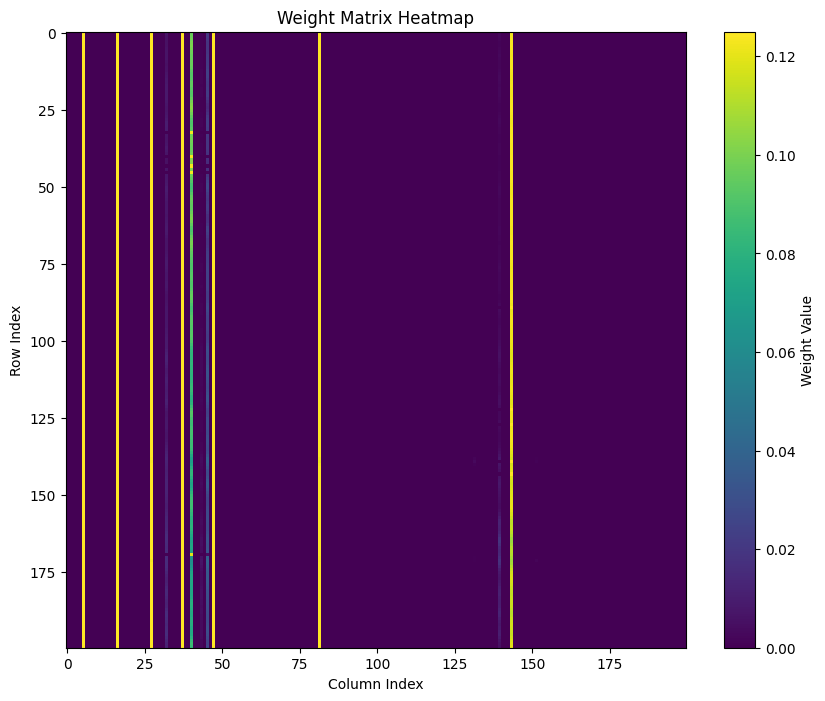

In [13]:
# Example usage
#caw = decoder_weights.cpu().detach().numpy()
#generate_heatmap(cross_weights.mean(axis=0))
generate_heatmap(self_attention_weights.detach().mean(axis=0))

# Ablation study
In this study we remove the encoder when testing the model

In [14]:
# If you need to load these weights later
model = Transformer(embed_dim=embedding_dim, a=0, max_seq_length=L, num_spins=3, proj_layer_dim=128, dropout=dropout_rate)
decoder_weights = torch.load('model_decoder/decoder_weights_experiment_batch.pth')
model.decoder_layer.load_state_dict(decoder_weights)

# Save the weights of the FC layer
#torch.save(model.fc.state_dict(), 'model_decoder/transformer_fc_weights.pth')

# To load these weights back into the FC layer later
fc_weights = torch.load('model_decoder/transformer_fc_weights_batch.pth')
model.fc.load_state_dict(fc_weights)

<All keys matched successfully>

In [15]:
class TransformerAblated(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout):
        super(TransformerAblated, self).__init__()
        self.word_embeddings = nn.Embedding(num_spins+1, embed_dim)
        self.decoder_layer = DecoderLayer(embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout)
        self.fc = nn.Linear(embed_dim, num_spins)

    def forward(self, tgt):
        tgt_embedded = self.word_embeddings(tgt)
        dec_output = self.decoder_layer(tgt_embedded, tgt_embedded)
        output = self.fc(dec_output)
        return output
    
    def get_cross_attention_weights(self):
        return self.decoder_layer.cross_attn_weights
    
    def get_self_attention_weights(self):
        return self.decoder_layer.decoder_attn_weights

In [16]:
# Create an instance of the new model
new_model = TransformerAblated(embed_dim=embedding_dim, a=0, max_seq_length=L, num_spins=3, proj_layer_dim=128, dropout=dropout_rate)

# Load the saved decoder weights
decoder_weights = torch.load('model_decoder/decoder_weights.pth')
new_model.decoder_layer.load_state_dict(decoder_weights)

# Load the saved FC weights
fc_weights = torch.load('model_decoder/transformer_fc_weights.pth')
new_model.fc.load_state_dict(fc_weights)


<All keys matched successfully>

In [17]:
# Define the parameters 
L = 200
embedding_dim = 200
proj_layer_dim = 128
hidden_dim = 200
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-1
num_sequences = 1000
num_epochs = 15
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [18]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="cross_attention_experiment",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "Transformer",
    "dataset": "ms_sequences_with_different_probability",
    "epochs": num_epochs,
    }
)

In [19]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
vocab = {0:0,1:1,2:2}
path = '/Users/mariayuffa/semester-project-1/runs'

#training_script(path, model, data_train=enc_train_loader, data_train_dec=dec_train_loader,
#                data_test=enc_test_loader, data_test_dec=dec_test_loader, vocab=vocab, optimizer=optimizer,
#                criterion=criterion, one_hot_flag=False, num_epochs=num_epochs, device=0)

#loss, weights = train(model, new_model, tensor_samples_train, tensor_chains_train, tensor_samples_test, tensor_chains_test, vocab, optimizer, criterion, device=device)
store_cross_attention, store_decoder_attention = training_script_ablated(path, model, new_model, enc_train_loader, dec_train_loader, enc_test_loader, dec_test_loader, vocab, optimizer, criterion, one_hot_flag=False, num_epochs=num_epochs, device=0)
wandb.finish()

  0%|          | 0/15 [00:00<?, ?it/s]/Users/mariayuffa/semester-project-1/utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(masked_sequences, dtype=torch.long), masked_positions
 20%|██        | 32/157 [00:03<00:12, 10.01it/s]


Epoch 1 | Train Loss: 2.4822


  7%|▋         | 1/15 [00:03<00:52,  3.73s/it]

Epoch 1 | Eval Loss: 1.1567


 20%|██        | 32/157 [00:02<00:11, 11.01it/s]


Epoch 2 | Train Loss: 0.7476


 13%|█▎        | 2/15 [00:07<00:46,  3.55s/it]

Epoch 2 | Eval Loss: 0.6968


 20%|██        | 32/157 [00:02<00:11, 10.97it/s]


Epoch 3 | Train Loss: 0.6990


 20%|██        | 3/15 [00:10<00:41,  3.49s/it]

Epoch 3 | Eval Loss: 0.7066


 20%|██        | 32/157 [00:02<00:11, 10.84it/s]


Epoch 4 | Train Loss: 0.7001


 27%|██▋       | 4/15 [00:14<00:38,  3.48s/it]

Epoch 4 | Eval Loss: 0.6932


 20%|██        | 32/157 [00:03<00:11, 10.61it/s]


Epoch 5 | Train Loss: 0.7001


 33%|███▎      | 5/15 [00:17<00:34,  3.49s/it]

Epoch 5 | Eval Loss: 0.6930


 20%|██        | 32/157 [00:02<00:11, 11.07it/s]


Epoch 6 | Train Loss: 0.7042


 40%|████      | 6/15 [00:20<00:31,  3.46s/it]

Epoch 6 | Eval Loss: 0.6955


 20%|██        | 32/157 [00:02<00:11, 11.13it/s]


Epoch 7 | Train Loss: 0.7040


 47%|████▋     | 7/15 [00:24<00:27,  3.43s/it]

Epoch 7 | Eval Loss: 0.6956


 20%|██        | 32/157 [00:03<00:12, 10.09it/s]


Epoch 8 | Train Loss: 0.7026


 53%|█████▎    | 8/15 [00:27<00:24,  3.51s/it]

Epoch 8 | Eval Loss: 0.6946


 20%|██        | 32/157 [00:02<00:11, 11.11it/s]


Epoch 9 | Train Loss: 0.6983


 60%|██████    | 9/15 [00:31<00:20,  3.47s/it]

Epoch 9 | Eval Loss: 0.6963


 20%|██        | 32/157 [00:02<00:11, 11.10it/s]


Epoch 10 | Train Loss: 0.6964


 67%|██████▋   | 10/15 [00:34<00:17,  3.44s/it]

Epoch 10 | Eval Loss: 0.6955


 20%|██        | 32/157 [00:02<00:11, 11.09it/s]


Epoch 11 | Train Loss: 0.6981


 73%|███████▎  | 11/15 [00:38<00:13,  3.42s/it]

Epoch 11 | Eval Loss: 0.6927


 20%|██        | 32/157 [00:02<00:11, 11.09it/s]


Epoch 12 | Train Loss: 0.6967


 80%|████████  | 12/15 [00:41<00:10,  3.49s/it]

Epoch 12 | Eval Loss: 0.7257


 20%|██        | 32/157 [00:02<00:11, 10.73it/s]


Epoch 13 | Train Loss: 0.7168


 87%|████████▋ | 13/15 [00:45<00:06,  3.49s/it]

Epoch 13 | Eval Loss: 0.6938


 20%|██        | 32/157 [00:02<00:11, 11.08it/s]


Epoch 14 | Train Loss: 0.7047


 93%|█████████▎| 14/15 [00:48<00:03,  3.45s/it]

Epoch 14 | Eval Loss: 0.7069


 20%|██        | 32/157 [00:02<00:11, 10.81it/s]


Epoch 15 | Train Loss: 0.7084


100%|██████████| 32/32 [00:00<00:00, 64.99it/s]


Epoch 15 | Eval Loss: 0.6937


eval_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▃▃▃▁▃▃▂▃▂▄▂▃
eval_loss,0.69371
train_loss,0.71187


# Extracting activations

In [20]:
# loading self-attention weights
#cross_attention_weights = torch.load('model_decoder/transformer_cross_attn_weights.pth')
cross_attention_weights = new_model.get_cross_attention_weights()
self_attention_weights = new_model.get_self_attention_weights()

print("Cross-attention weights:", cross_attention_weights.shape)
print("Self-attention weights:", self_attention_weights.shape)

Cross-attention weights: torch.Size([8, 200, 200])
Self-attention weights: torch.Size([8, 200, 200])


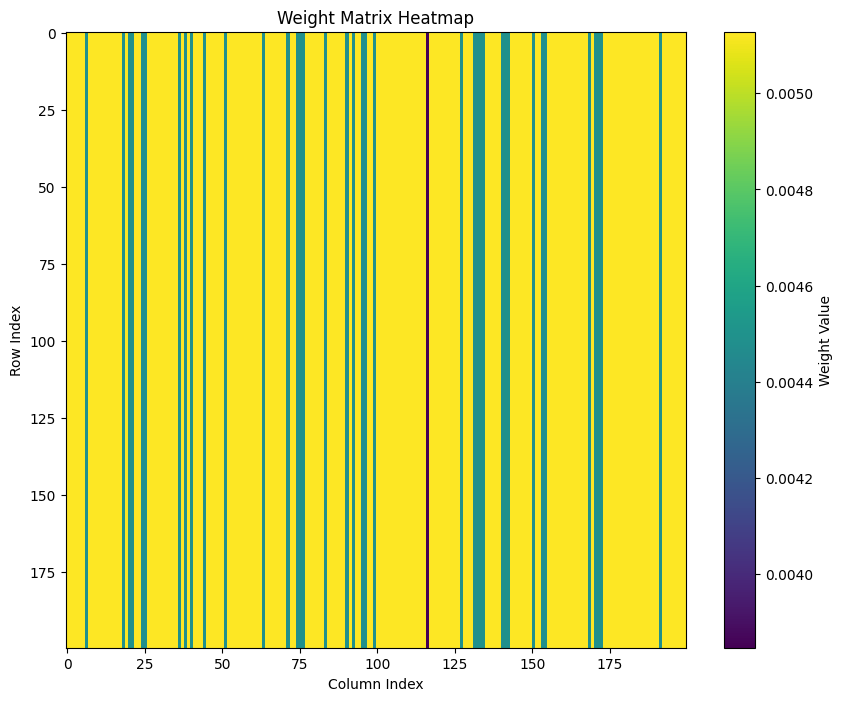

In [21]:
generate_heatmap(cross_attention_weights.mean(0).detach().numpy())

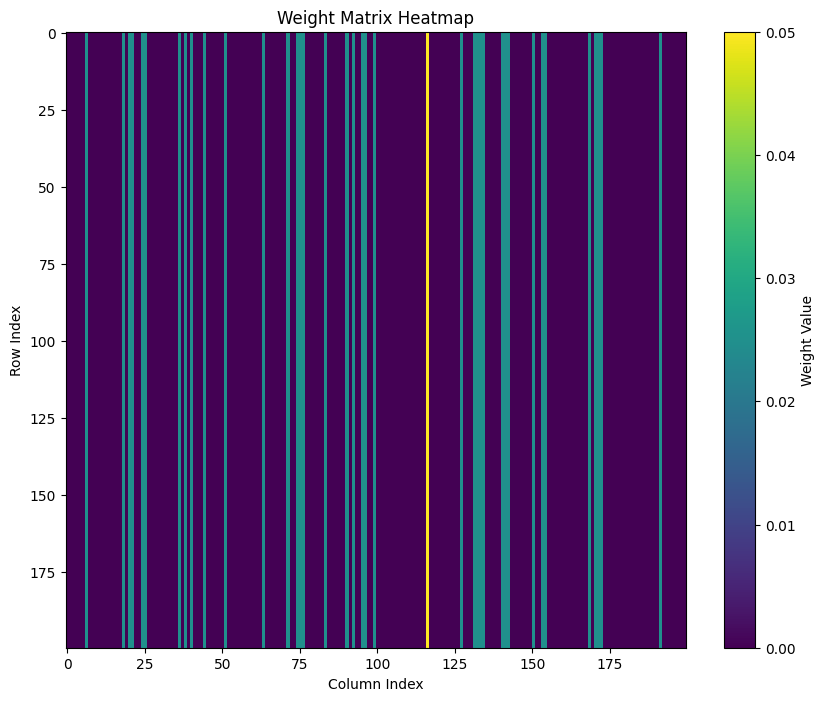

In [22]:
generate_heatmap(self_attention_weights.mean(0).detach().numpy())